In [2]:
import torch

In [8]:
!python3 --version

Python 3.9.18


In [43]:
print(torch.__version__)

2.1.0.post100


In [3]:
#create tensor
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])

In [4]:
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

In [34]:
#check for cuda
torch.cuda.is_available()

False

# Problem 3. 

Create a Python function of three arguments, x,y, and z

loss(x,y,z)=  x^2/(y+ z^3 ) + e^(-(x^2+3*z/y))

Calculate the gradients of that function at points (x,y,z)=(0,1,-2) and (x,y,z)=(1,-1,0). Perform the calculations using Calculus and Pytorch autograd. 
(20%)



## analytical solution of gradient by calculus

a) at p1 = (0,1,-2), gradient of loss(x,y,z) = ( 0, -6e^6, -3e^6 ) 

b) at p2 = (1, -1, 0), gradient of loss(x,y,z) = ( -2-2e^-1, -1, 3e^-1 )



## solution using Pytorch autograd

In [11]:
import numpy as np

In [122]:
#define the loss function
def loss(x,y,z):
    l = x**2/(y+z**3) + torch.exp(-(x**2+3*z/y))
    l.retain_grad()
    return l


In [123]:
#define p1 = (0,1,-2)
x = torch.tensor([0.0], requires_grad=True)
y = torch.tensor([1.0], requires_grad=True)
z = torch.tensor([-2.0], requires_grad=True)

In [124]:
loss1 = loss(x,y,z)

In [125]:
loss1.backward()

In [127]:
#gradient of loss(x,y,z) at p1
print("grad x:", x.grad)
print("grad y:", y.grad)
print("grad z:", z.grad)

grad x: tensor([-0.])
grad y: tensor([-2420.5728])
grad z: tensor([-1210.2864])


In [120]:
#define p2 = (1,-1,0)
x2 = torch.tensor([1.0], requires_grad=True)
y2 = torch.tensor([-1.0], requires_grad=True)
z2 = torch.tensor([0.0], requires_grad=True)

In [128]:
loss2 = loss(x2,y2,z2)

In [129]:
loss2.backward()

In [130]:
#gradient of loss(x,y,z) at p2
print("grad x2:", x2.grad)
print("grad y2:", y2.grad)
print("grad z2:", z2.grad)

grad x2: tensor([-2.7358])
grad y2: tensor([-1.])
grad z2: tensor([1.1036])


## As we see above, the analytical solutions and autograd solutions are the same.

# Problem 4. 

- Extend the dataset to 100 points by creating a random cloud of data points.
- For example, you could start with an equally spaced set of points between -20 and 45oC. Calculate Fahrenheit values using exact transformation. To both values add Gaussian noise of standard deviation 3oC.
- Transform your data into two datasets 70% for training and 30% for the validation data.
- Treate Celsius values as features and Fahrenheit values as targets.
- You have to shuffle your data.
- Construct corresponding dataloaders with batch = 10.
- Use Adam as the optimizer and Mean Square Error as the loss function.
- Run your training for 3000 epochs.
- Trace and eventually plot training loss and the validation loss. Please present the scatter plot of your data and the prediction curve. 
(20%)


In [260]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image, ImageFile
torch.set_printoptions(edgeitems=2, linewidth=75)

In [157]:
#set seed and create random celsius data between -20 and 45
np.random.seed(42)
c = np.random.rand(100)
c = 65*c - 25

In [159]:
#calculate fahrenheit data
f = 9/5*c+32

In [160]:
#add gaussian noise to celsius array
c = c + 3*np.random.randn(100)

In [162]:
#add gaussian noise to fahrenheit array
f = f +3*np.random.randn(100)

In [289]:
#create celsius and F tensors and normalize F
t_c = torch.tensor(c, dtype=torch.float32)
t_f = torch.tensor(f, dtype=torch.float32)

#normalize F
t_fn = 0.1 * t_f

In [290]:
#shuffle tensors and create indices lists with 70% of data in the training set, 30% in validation set
n_samples = t_f.shape[0]
n_val = int(0.3 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices  # <1>

(tensor([35, 44, 38, 33, 15, 49, 80, 51, 10, 40, 61, 50, 46, 94, 45,  8, 65,
         32, 14, 77, 39,  3, 43, 21, 78, 83, 81, 47, 24, 42,  1, 92, 30, 73,
          4, 66, 16, 99,  5, 74, 71, 12, 31, 13, 11, 76, 22,  6, 63, 28, 55,
         79, 36, 60, 86, 54, 41, 67, 97, 72, 87, 37, 90, 29, 75, 34,  9, 96,
         91, 89]),
 tensor([19, 53, 23, 52, 56, 57, 58, 84, 85, 64, 18, 20, 27, 48, 98, 62, 82,
         95, 70, 25, 93, 68, 17, 59, 88,  2, 26,  7,  0, 69]))

In [291]:
#create training and validation tensors
train_t_f = t_f[train_indices]
train_t_c = t_c[train_indices]

val_t_f = t_f[val_indices]
val_t_c = t_c[val_indices]

train_t_fn = 0.1 * train_t_f
val_t_fn = 0.1 * val_t_f

In [292]:
class JointDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [293]:
#create training dataset and data loader
train_ds = TensorDataset(train_t_c, train_t_fn)

batch_size = 10
train_dl = DataLoader(train_ds, batch_size, shuffle=False)

In [294]:
#create val dataset and data loader
val_ds = TensorDataset(val_t_c, val_t_fn)

val_dl = DataLoader(val_ds, batch_size, shuffle=False)

In [295]:
for i, batch in enumerate(train_dl, 1):
    print(f'batch {i}:', batch)

batch 1: [tensor([ 27.4663,  -5.8062,  18.8981,  36.4542, -10.1728,  -6.4131,
         36.6990,  23.6847, -20.9158, -17.1716]), tensor([ 8.4989,  2.4221,  6.6109, 10.9578,  1.1028,  1.1895,  9.1784,
         7.4457, -0.9172, -0.1040])]
batch 2: [tensor([ -8.3285,  35.0514,  -0.5304,  22.4443,  15.3358,  11.6470,
         14.1967, -19.9990, -12.8901, -19.4903]), tensor([ 1.9307, 10.0634,  2.5529,  8.1527,  5.8913,  5.6660,  5.0151,
        -0.3844,  0.6934, -0.1239])]
batch 3: [tensor([  4.5146,   7.9501,  36.3616, -15.1497,  -0.8205, -18.8990,
         16.9359,   4.5989,   0.3984, -19.3363]), tensor([ 4.0775,  6.5204,  9.3636,  0.3782,  2.4382, -0.3240,  5.7803,
         4.3010,  4.1434, -1.0433])]
batch 4: [tensor([ 35.8994,  23.7149,  20.1490,  28.8959, -15.5178, -20.6624,
         -7.3304, -15.5055, -13.7890,  21.6972]), tensor([10.2594,  7.4692,  5.9628,  8.3624,  0.7131,  0.5003,  2.3239,
         0.1010,  0.2680,  6.5920])]
batch 5: [tensor([-16.0449,  27.5195, -13.3922,  -9.6582

In [296]:
#define the linear model
def model(t_c, w, b):
    return w * t_c + b

In [297]:
#define the loss function
def loss_fn(t_p, t_f):
    squared_diffs = (t_p - t_f)**2
    return squared_diffs.mean()

In [331]:
#define the training loop
def training_loop(n_epochs, optimizer, params, train_dl, val_dl):
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(1, n_epochs + 1):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch, *params)
            train_loss = loss_fn(pred, y_batch)
            
            
        # # Context manager here
        with torch.no_grad(): # <1>
            for x_batch, y_batch in val_dl:
                val_t_p = model(x_batch, *params)
                val_loss = loss_fn(pred, y_batch)
                
                assert val_loss.requires_grad == False # Cheking that requires_grad is set to False

        train_loss_list.append(train_loss.detach().numpy())
        val_loss_list.append(val_loss.detach().numpy())
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}")
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
        
    return params, train_loss_list, val_loss_list

In [332]:
#Run the training loop with learning_rate=1e-2. Validation loss plateued around ~15.

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate)

train_loss_list = []
val_loss_list = []
params, train_loss_list, val_loss_list = training_loop(
                                            n_epochs = 3000, 
                                            optimizer = optimizer,
                                            params = params,
                                            train_dl = train_dl,
                                            val_dl = val_dl)

Epoch 1, Training loss 214.0822, Validation loss 284.3834
Epoch 2, Training loss 208.4535, Validation loss 278.1138
Epoch 3, Training loss 202.9062, Validation loss 271.9259
Epoch 4, Training loss 197.4417, Validation loss 265.8211
Epoch 5, Training loss 192.0612, Validation loss 259.8011
Epoch 6, Training loss 186.7661, Validation loss 253.8670
Epoch 7, Training loss 181.5574, Validation loss 248.0203
Epoch 8, Training loss 176.4362, Validation loss 242.2623
Epoch 9, Training loss 171.4035, Validation loss 236.5940
Epoch 10, Training loss 166.4603, Validation loss 231.0168
Epoch 11, Training loss 161.6074, Validation loss 225.5313
Epoch 12, Training loss 156.8456, Validation loss 220.1388
Epoch 13, Training loss 152.1755, Validation loss 214.8400
Epoch 14, Training loss 147.5976, Validation loss 209.6356
Epoch 15, Training loss 143.1125, Validation loss 204.5262
Epoch 16, Training loss 138.7205, Validation loss 199.5125
Epoch 17, Training loss 134.4220, Validation loss 194.5949
Epoch 

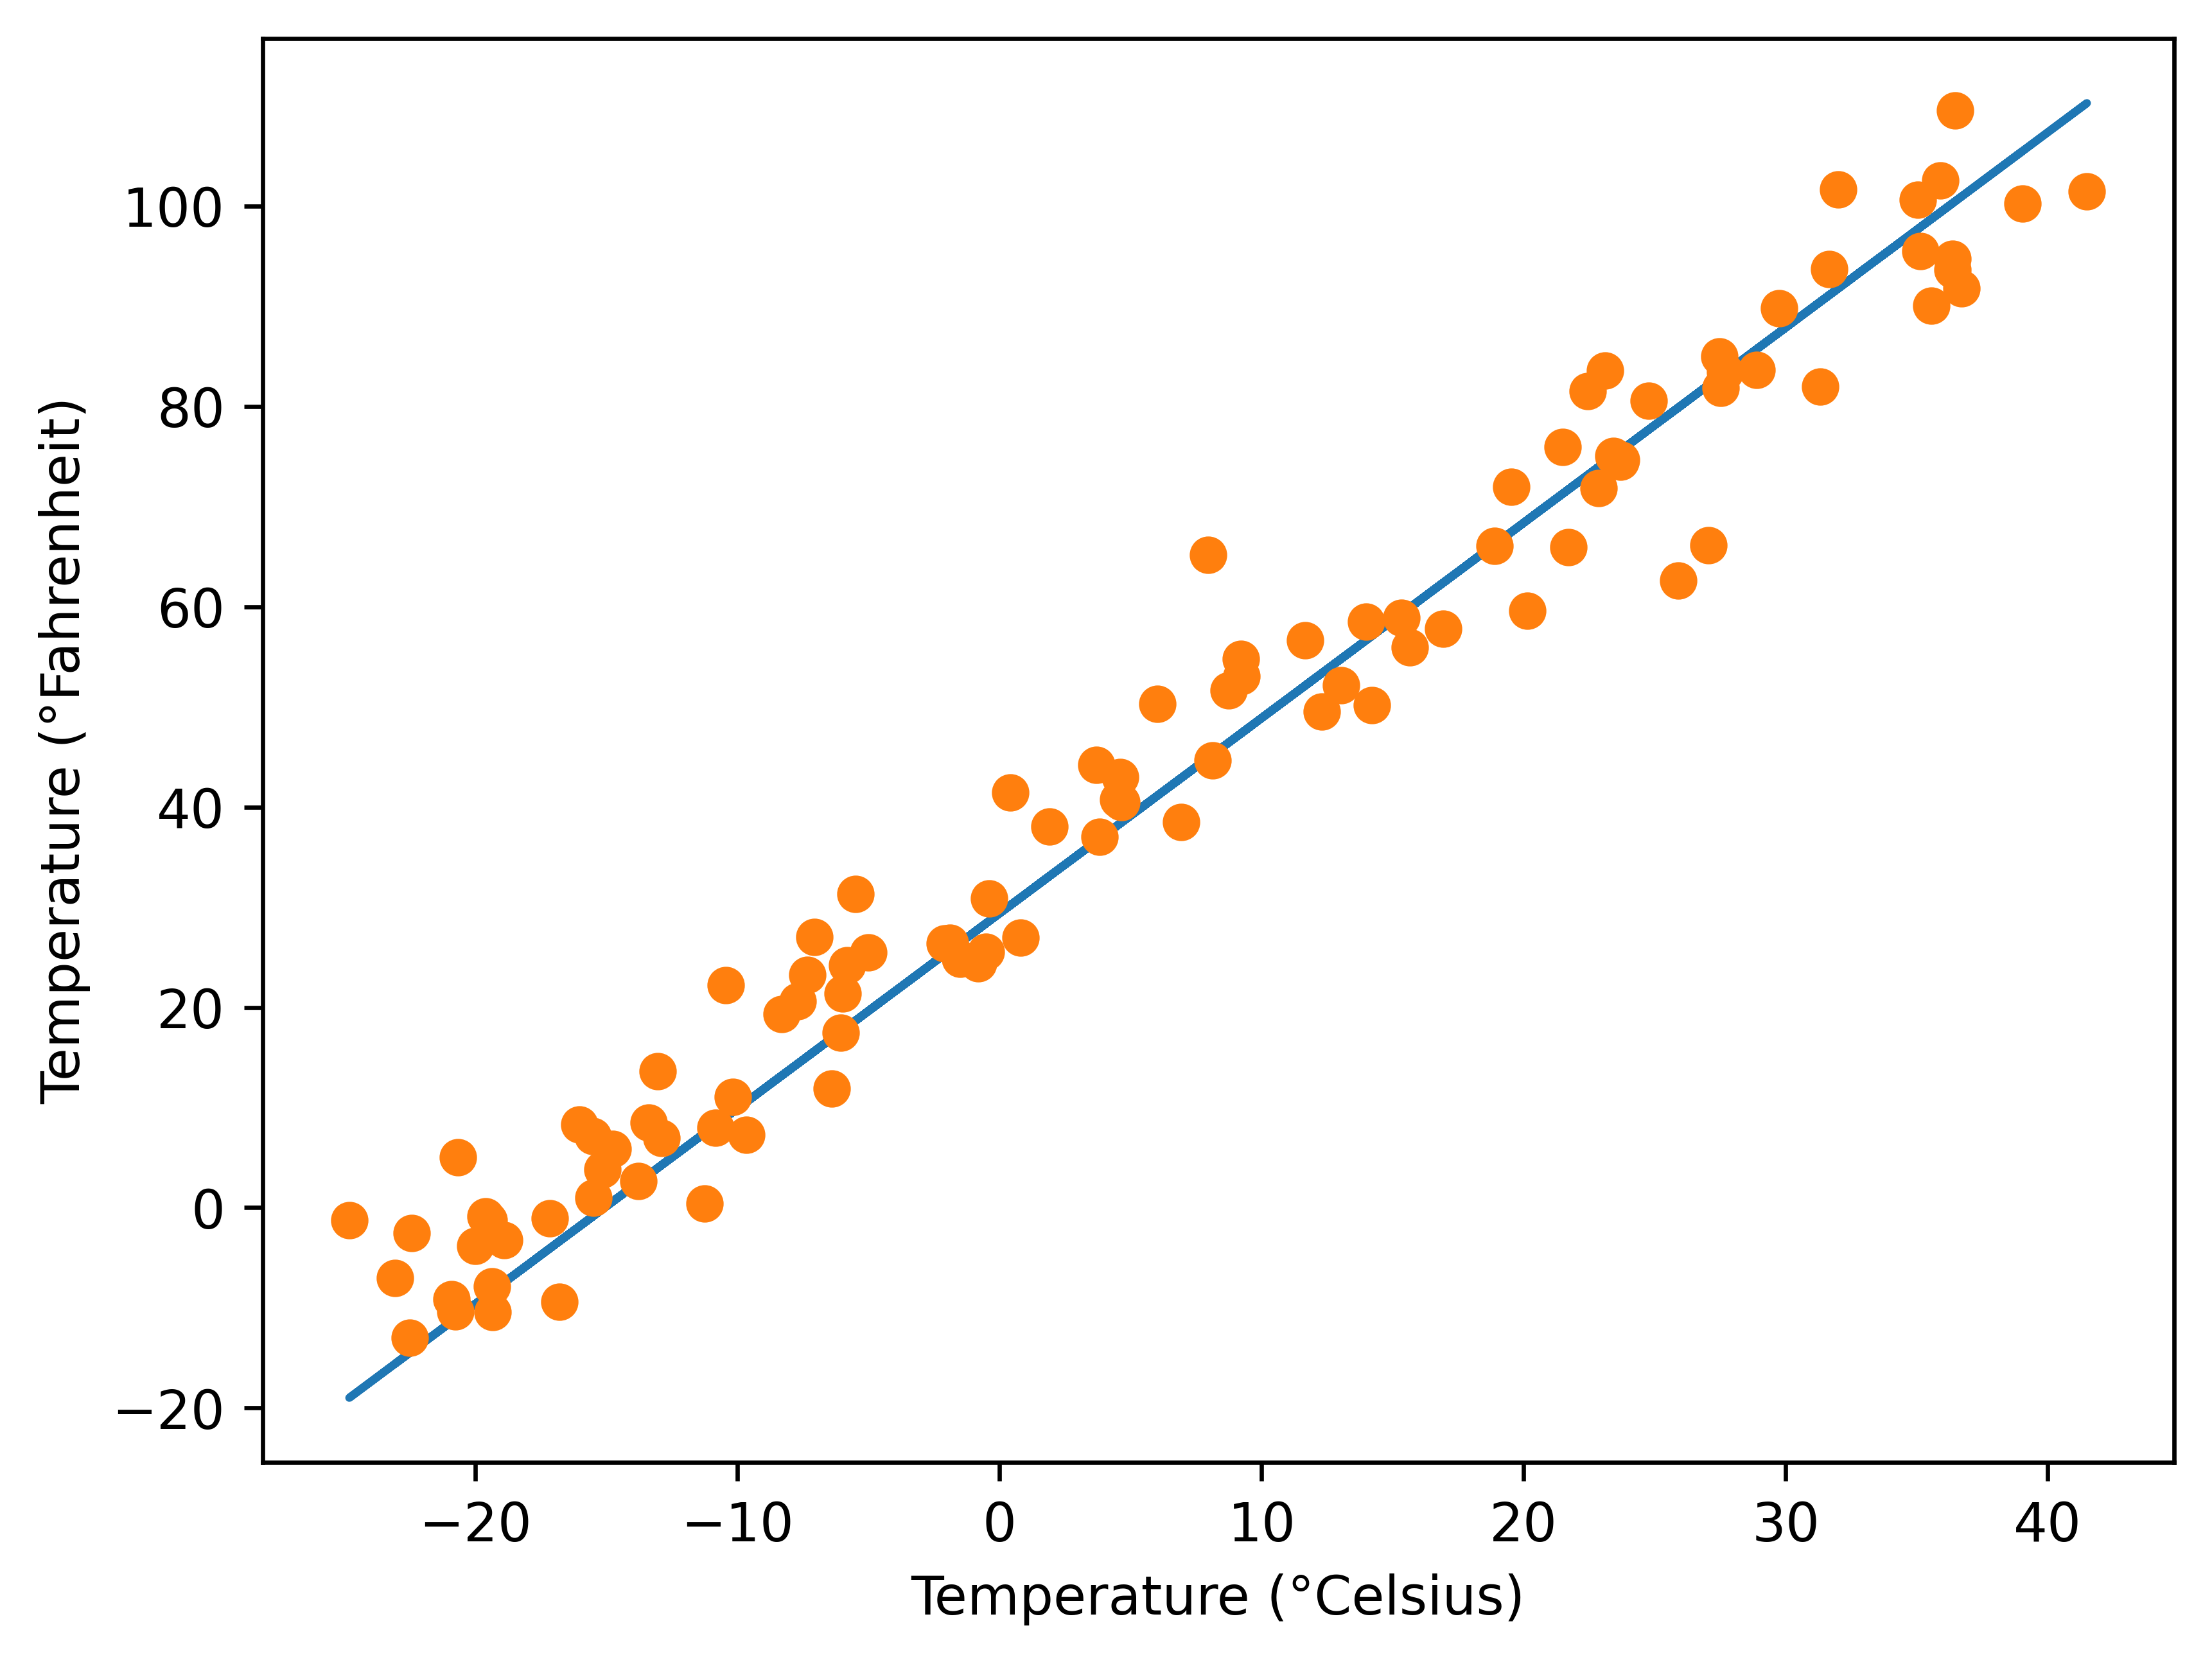

In [309]:
#plot the figure

%matplotlib inline
from matplotlib import pyplot as plt
# Remember that we’re training on the normalized Fahreinheit units. We also use argument unpacking.
t_p = model(t_c, *params)/0.1  # adjust for normalization of F units

fig = plt.figure(dpi=600)
plt.ylabel("Temperature (°Fahrenheit)")
plt.xlabel("Temperature (°Celsius)")
plt.plot(t_c.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_c.numpy(), t_f.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

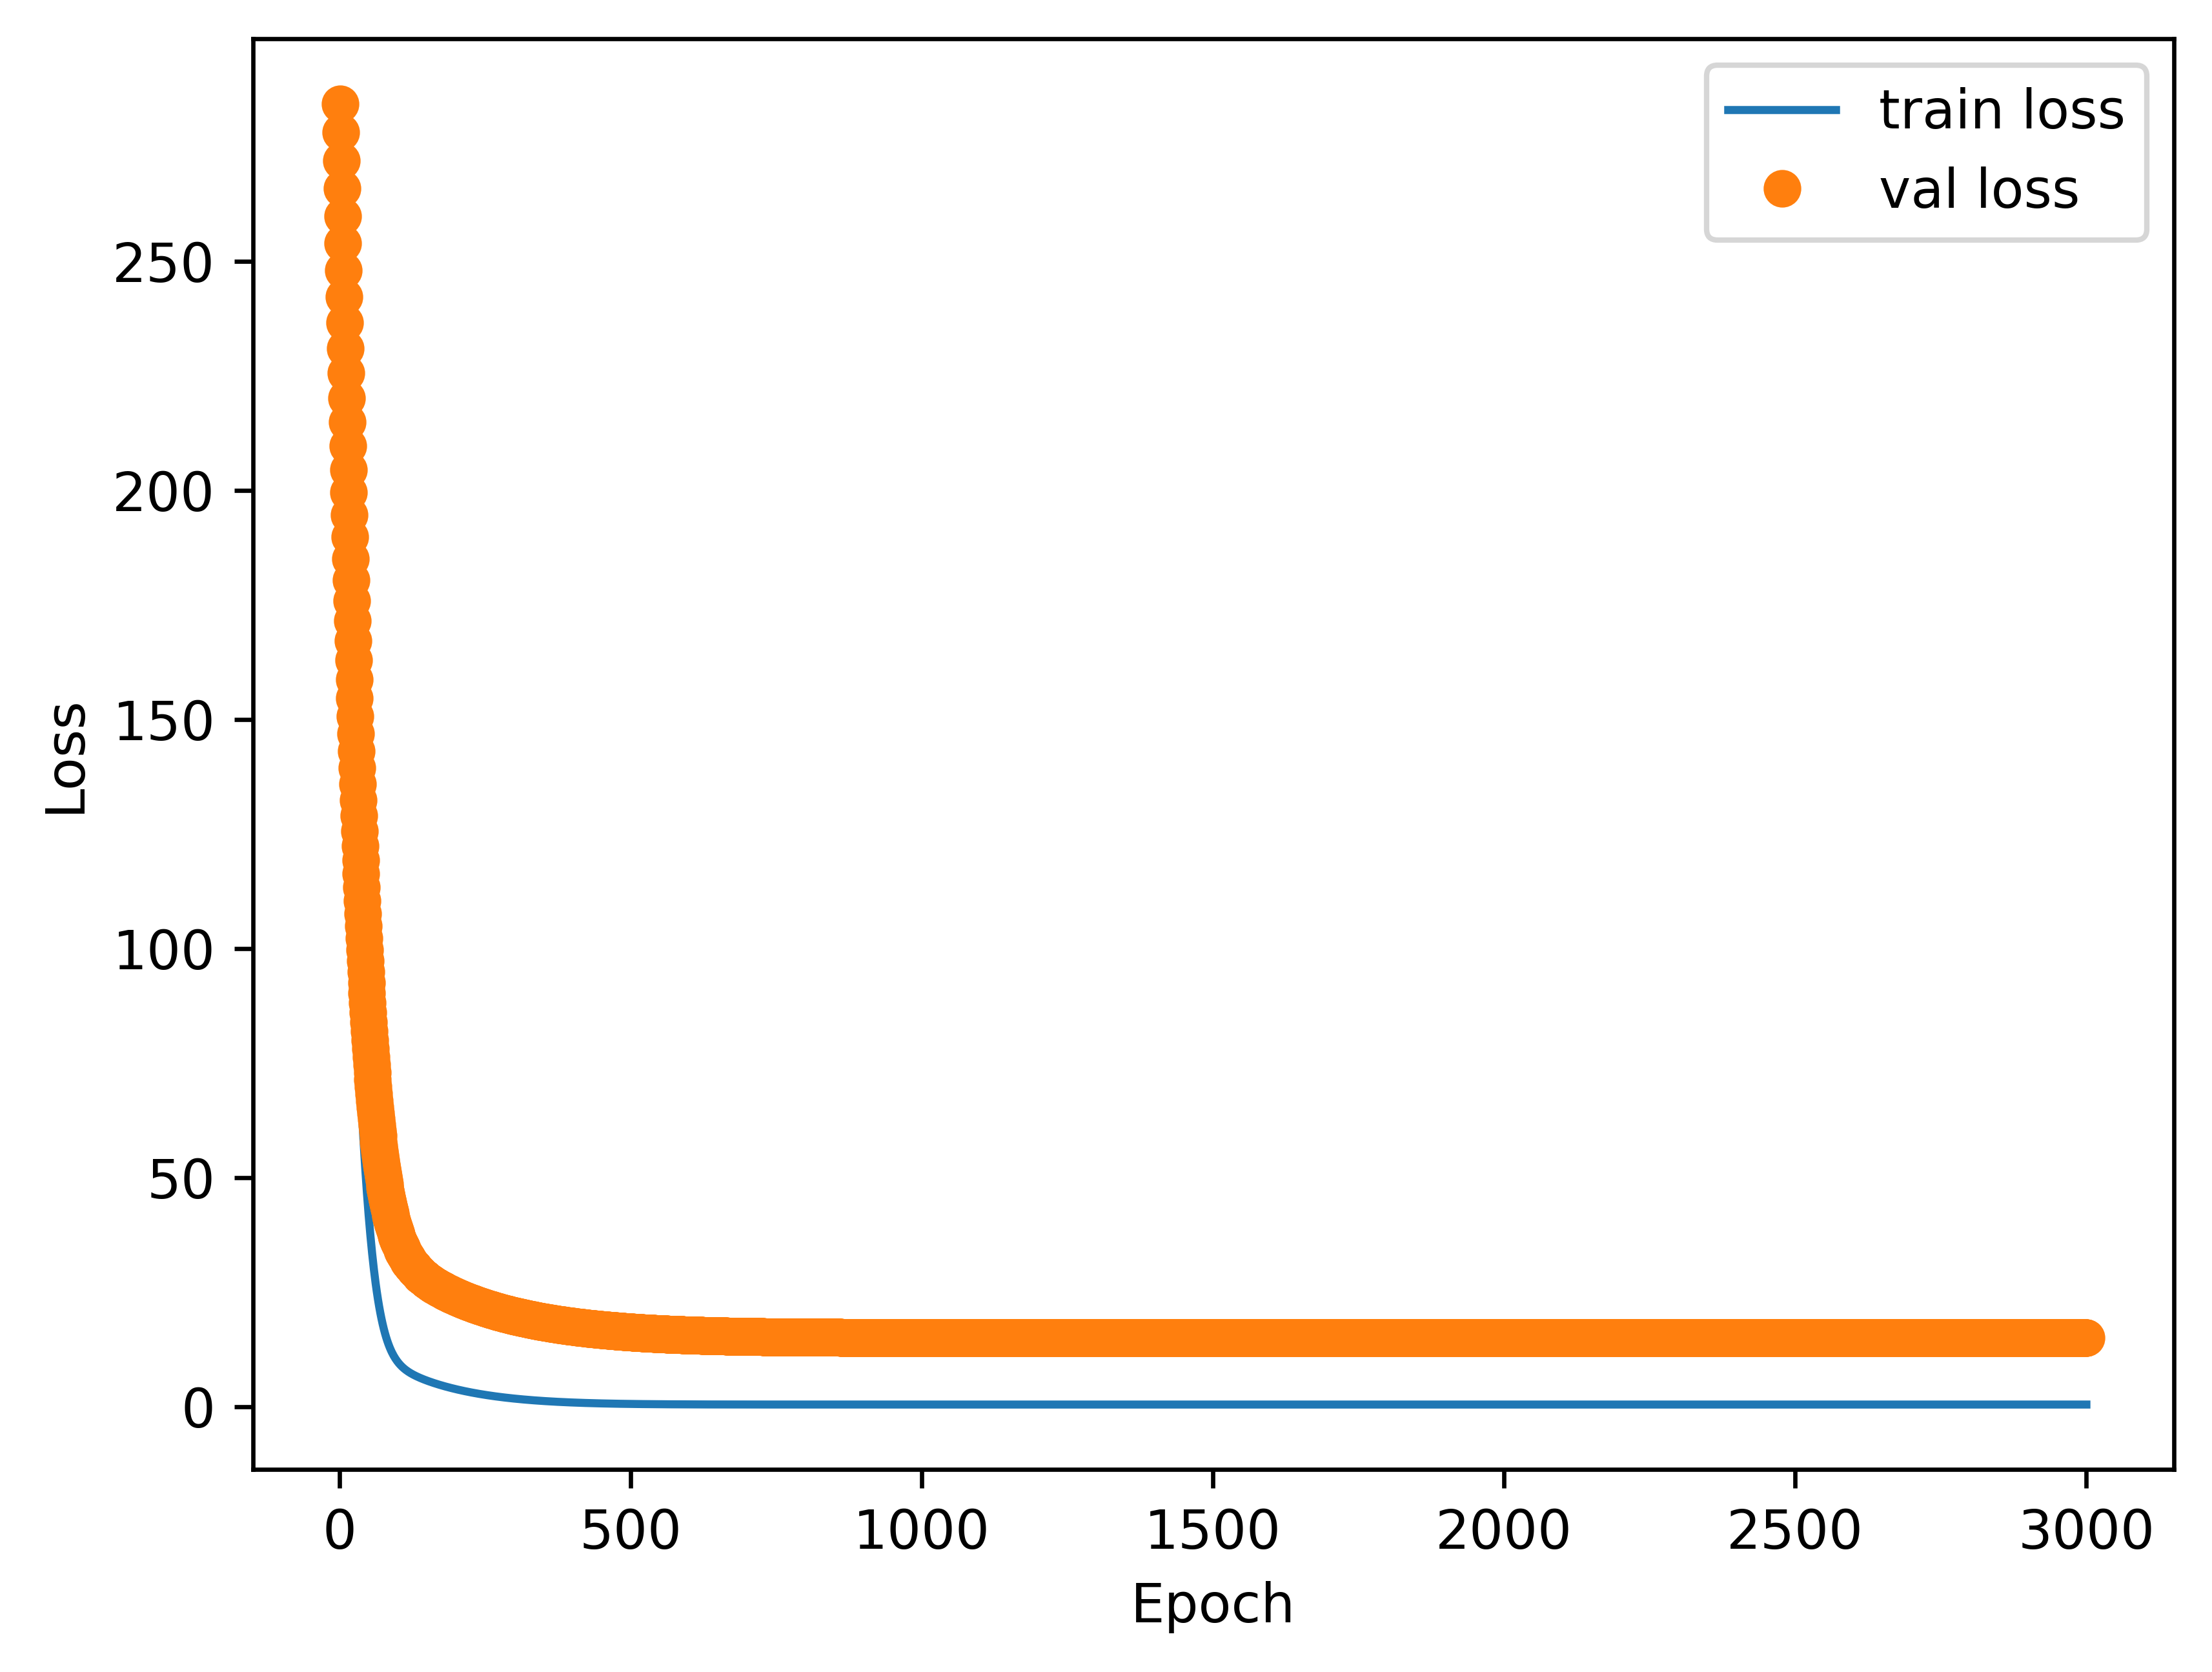

In [337]:
epoch = range(1, 3001)
fig = plt.figure(dpi=600)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(epoch, train_loss_list, label='train loss') # <2>
plt.plot(epoch, val_loss_list, 'o', label='val loss')
plt.legend()

# Problem 5. 

- Use NAdam optimizer and CrossEntropyLoss loss function.
- Track training loss and the validation loss for 40 epochs and plot their evolution with the epoch.
- Enable the same tracking and visualization in the existing code with Adam optimizer. Report if there are any difference. Report if there are none.
- Track the evolving accuracy of your model using training data and separately validation data.
- Present visually two accuracies as they evolve with epochs. 
(30%)



In [339]:
#define convolutional network
class CNNNet(nn.Module):

    def __init__(self, num_classes=2):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [344]:
#define check image function
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [345]:
#define img transformation function
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])


In [349]:
#set device
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [346]:
#create training and validation datasets
train_data_path = "/Users/mpellegrin008/Documents/VS Code/CSCI104_Advanced_DL/cats_and_fish/train"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "/Users/mpellegrin008/Documents/VS Code/CSCI104_Advanced_DL/cats_and_fish/val"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64

In [347]:
#create training and validation dataloaders
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


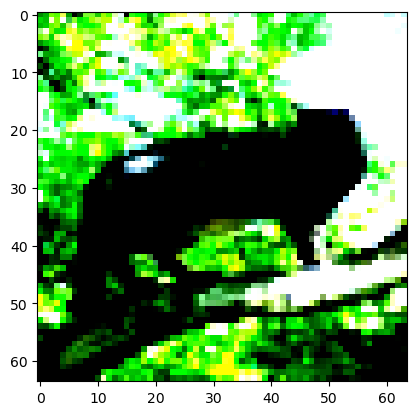

Label: 0


In [384]:
#inspect image and label to confirm label mapping
train_features, train_labels = next(iter(train_data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [383]:
#set optimizer and instantiate CNN
cnnnet = CNNNet()
cnnnet.to(device)
optimizer = optim.NAdam(cnnnet.parameters(), lr=0.001)

In [406]:
#define training loop
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    train_loss_list = []
    val_loss_list = []
    val_acc = []
    train_acc = []
    
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        train_num_correct = 0 
        train_num_examples = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)

            train_correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],
                               targets)
            train_num_correct += torch.sum(train_correct).item()
            train_num_examples += train_correct.shape[0]
        train_acc.append(train_num_correct/train_num_examples)
        
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],
                               targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        train_loss_list.append(training_loss)
        val_loss_list.append(valid_loss)
        val_acc.append(num_correct/num_examples)
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

    return train_loss_list, val_loss_list, val_acc, train_acc

In [396]:
#train the model using NAdam Optimizer
train_loss_list =[]
val_loss_list = []
val_acc = []

train_loss_list, val_loss_list, val_acc = train(cnnnet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=40, device=device)

Epoch: 1, Training Loss: 0.72, Validation Loss: 0.70, accuracy = 0.17
Epoch: 2, Training Loss: 0.70, Validation Loss: 0.78, accuracy = 0.24
Epoch: 3, Training Loss: 0.71, Validation Loss: 0.58, accuracy = 0.83
Epoch: 4, Training Loss: 1.29, Validation Loss: 0.67, accuracy = 0.83
Epoch: 5, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.83
Epoch: 6, Training Loss: 0.74, Validation Loss: 0.69, accuracy = 0.46
Epoch: 7, Training Loss: 0.72, Validation Loss: 0.70, accuracy = 0.25
Epoch: 8, Training Loss: 0.95, Validation Loss: 0.65, accuracy = 0.83
Epoch: 9, Training Loss: 0.98, Validation Loss: 0.71, accuracy = 0.17
Epoch: 10, Training Loss: 0.82, Validation Loss: 0.69, accuracy = 0.83
Epoch: 11, Training Loss: 0.71, Validation Loss: 0.64, accuracy = 0.83
Epoch: 12, Training Loss: 0.69, Validation Loss: 0.59, accuracy = 0.84
Epoch: 13, Training Loss: 0.67, Validation Loss: 0.69, accuracy = 0.83
Epoch: 14, Training Loss: 0.69, Validation Loss: 0.60, accuracy = 0.83
Epoch: 15, Trai

In [419]:
#inspect the prediction model on test images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


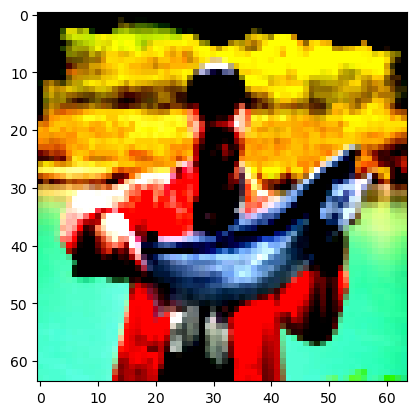

Label: 0
tensor(0)
cat


In [389]:
labels = ['cat','fish']

img = Image.open("/Users/mpellegrin008/Documents/VS Code/CSCI104_Advanced_DL/cats_and_fish/test/fish/1609947018_bfa1fcd6b2.jpg") 
img = img_transforms(img).to(device)
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")
img = torch.unsqueeze(img, 0)


cnnnet.eval()
prediction = F.softmax(cnnnet(img), dim=1)
prediction = prediction.argmax()
print(prediction)
print(labels[prediction])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


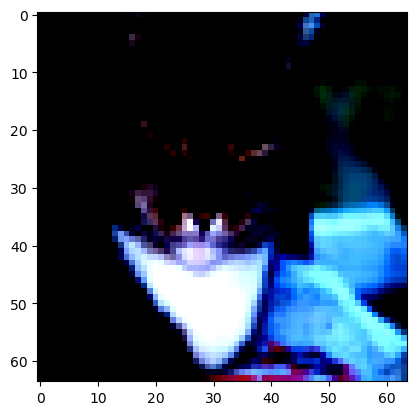

Label: 0
cat


In [390]:
labels = ['cat','fish']

img = Image.open("/Users/mpellegrin008/Documents/VS Code/CSCI104_Advanced_DL/cats_and_fish/test/cat/64486923_5e33b6db60.jpg") 
img = img_transforms(img).to(device)
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")
img = torch.unsqueeze(img, 0)

cnnnet.eval()
prediction = F.softmax(cnnnet(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction]) 

## as seen above, the model predicted correctly for each of the randomly chosen test images

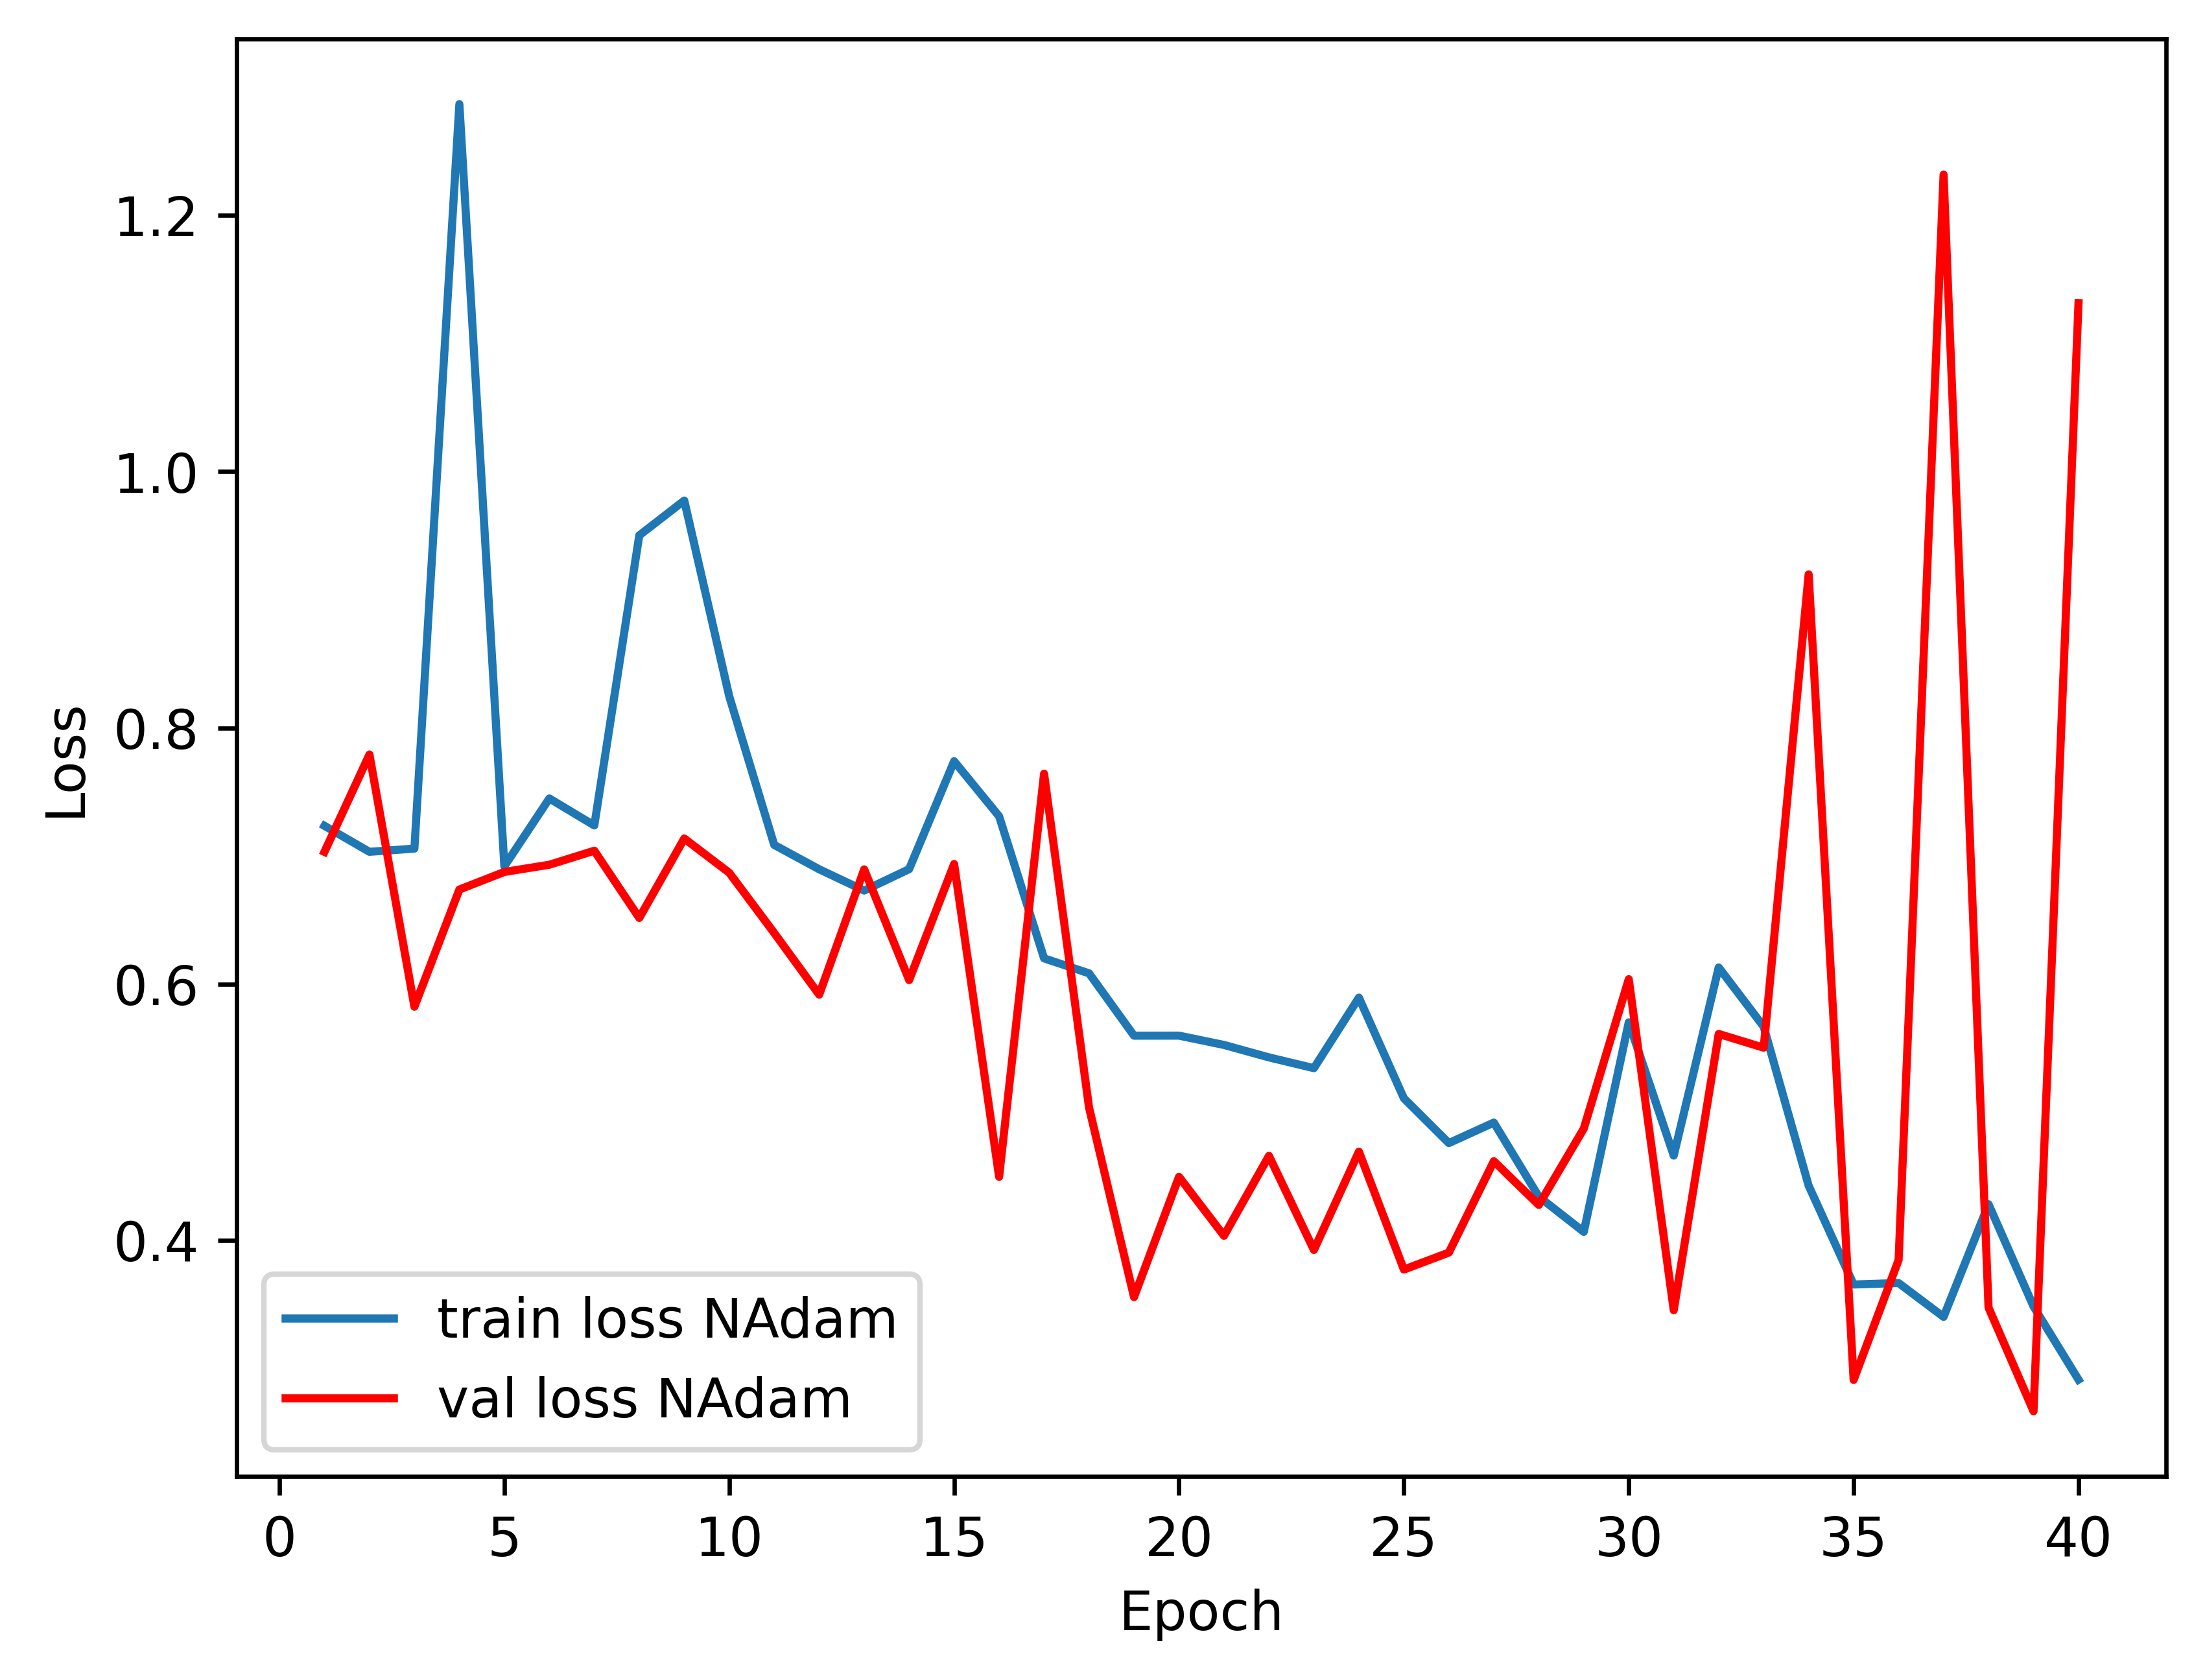

In [417]:
#plot of the results using NAdam Optimizer
epoch = range(1, 41)
fig = plt.figure(dpi=600)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(epoch, train_loss_list, label='train loss NAdam') # <2>
plt.plot(epoch, val_loss_list, 'r', label='val loss NAdam')
plt.legend()

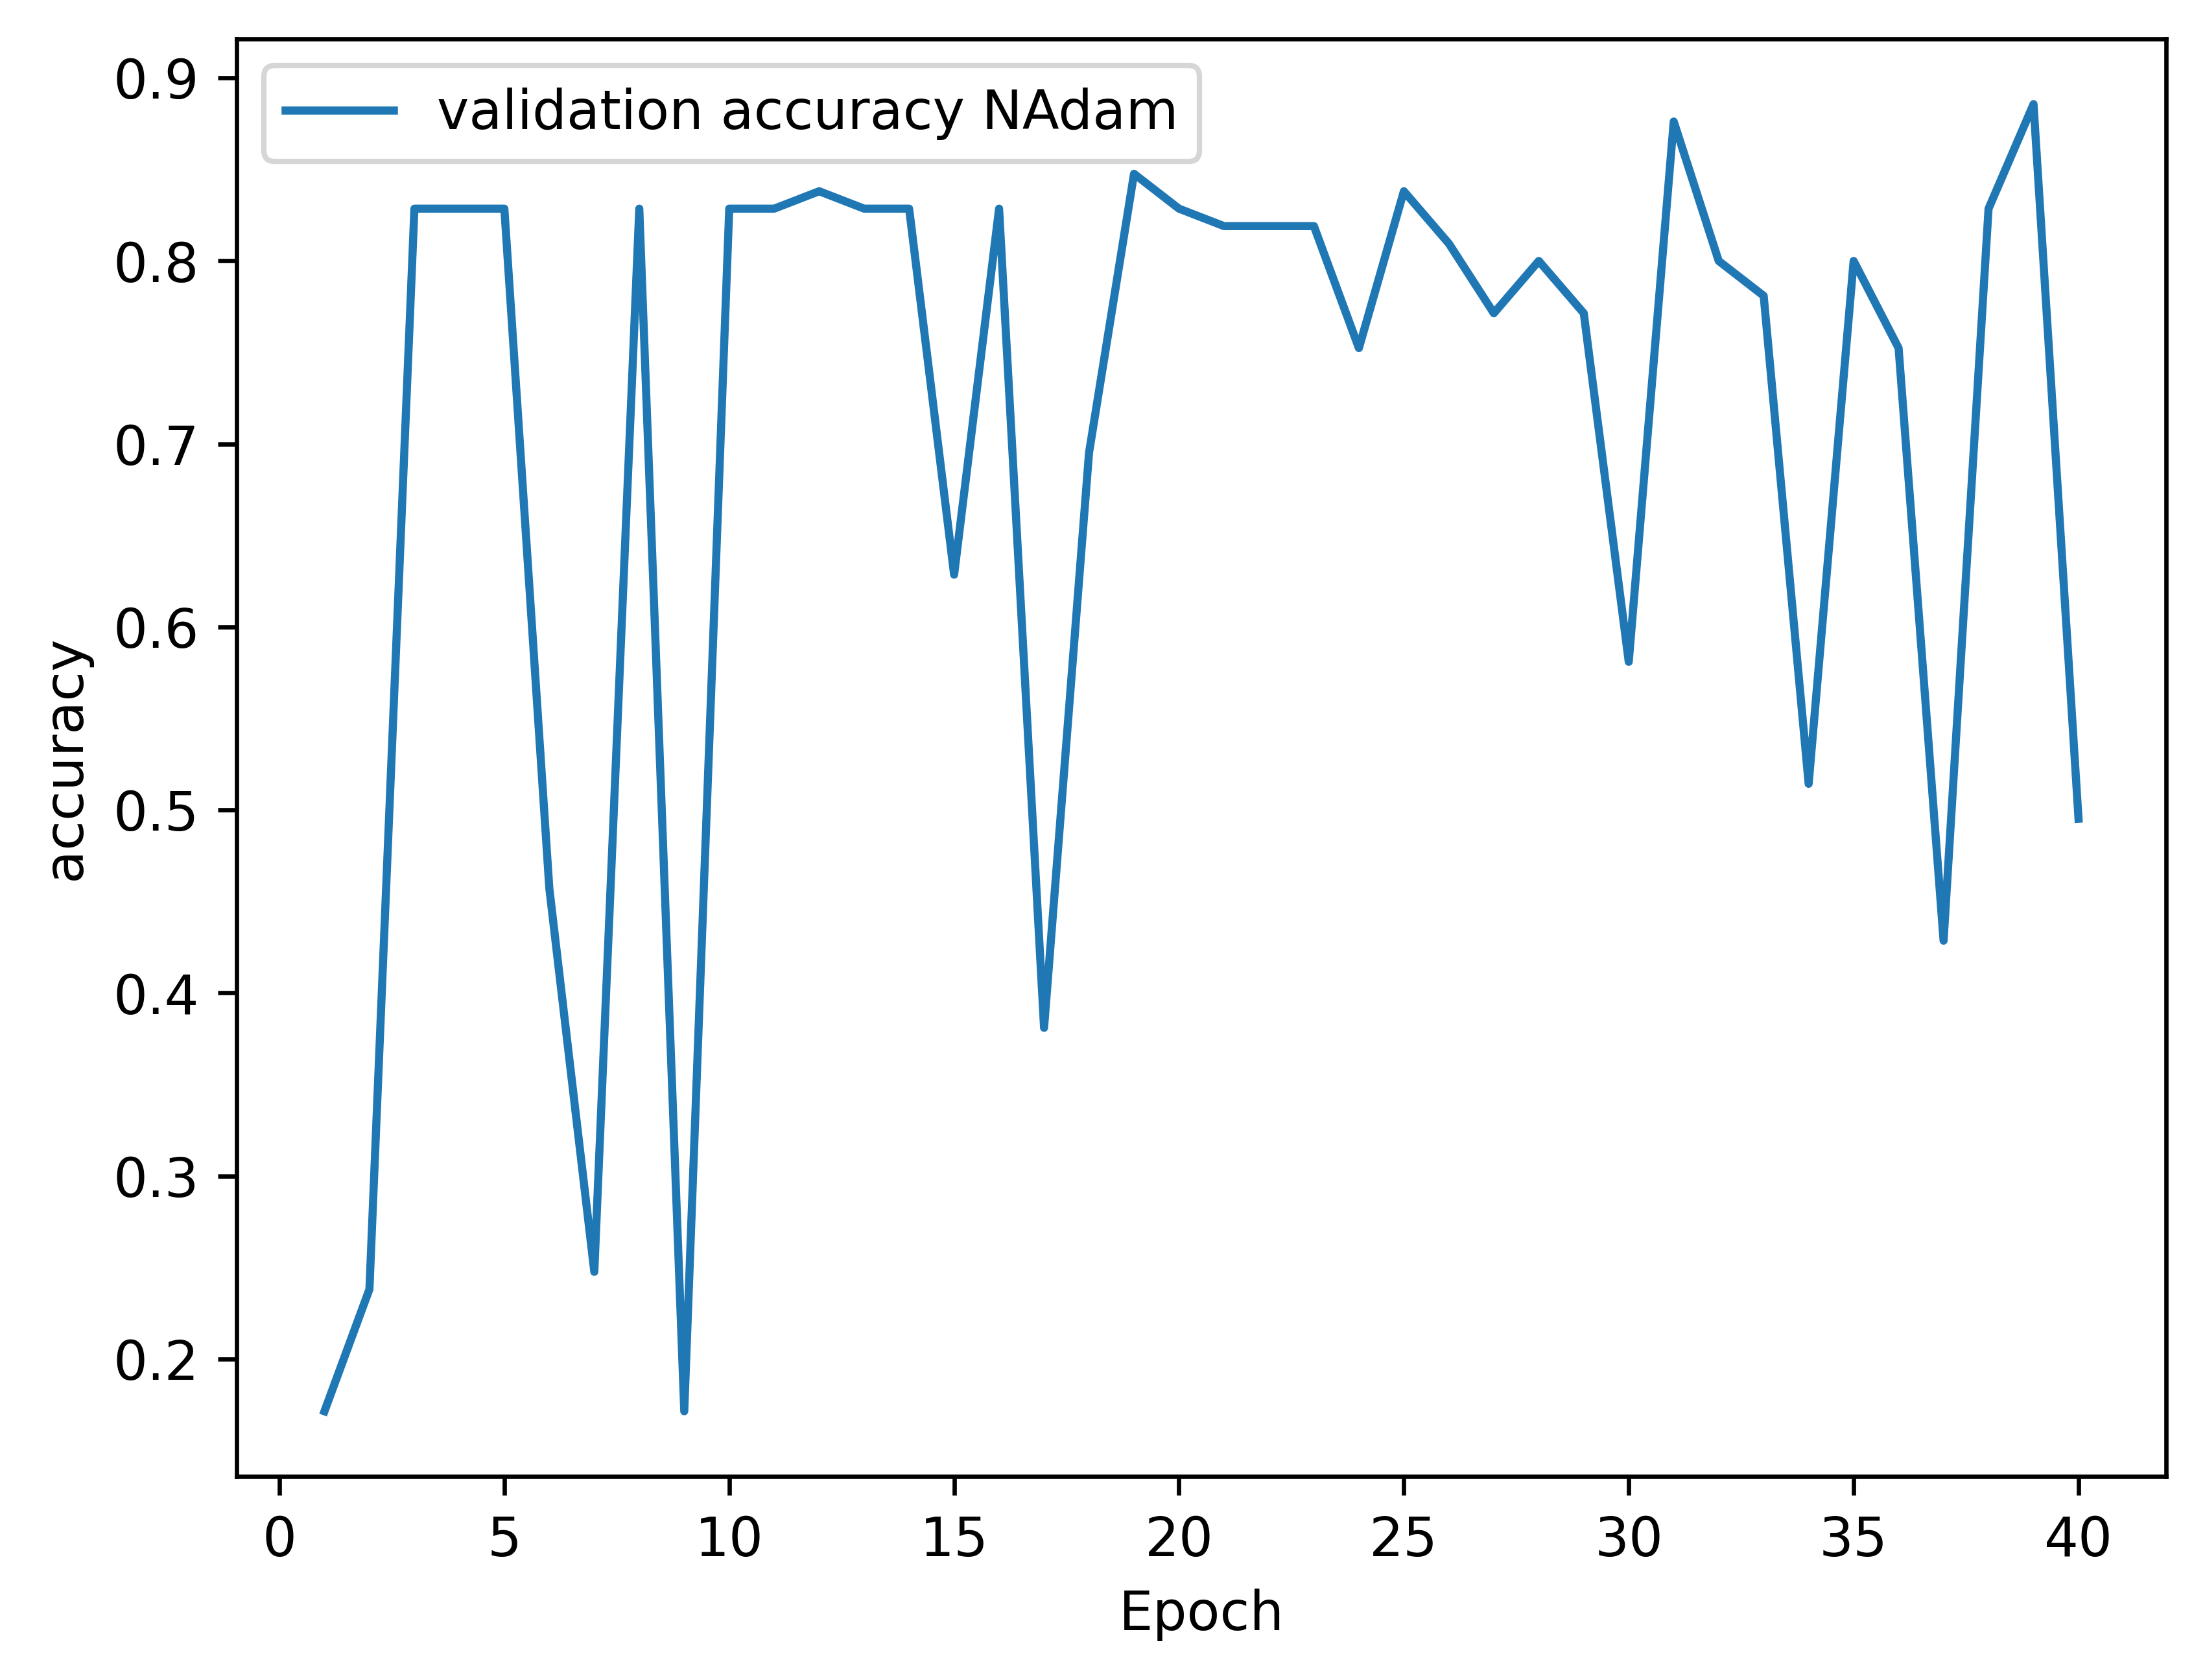

In [414]:
#plot validation accuracy for NAdam optimizer
epoch = range(1, 41)
fig = plt.figure(dpi=600)
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.plot(epoch, val_acc,  label='validation accuracy NAdam') # <2>
# plt.plot(epoch, val_loss_list, 'r', label='val loss')
plt.legend()

In [402]:
#change optimizer to Adam for comparison
optimizer = optim.Adam(cnnnet.parameters(), lr=0.001)

In [407]:
#train the model with Adam Optimizer
train_loss_list2 =[]
val_loss_list2 = []
val_acc2 = []
train_acc2 = []

train_loss_list2, val_loss_list2, val_acc2, train_acc2 = train(cnnnet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=40, device=device)

Epoch: 1, Training Loss: 0.12, Validation Loss: 0.60, accuracy = 0.78
Epoch: 2, Training Loss: 0.08, Validation Loss: 0.71, accuracy = 0.83
Epoch: 3, Training Loss: 0.16, Validation Loss: 0.51, accuracy = 0.81
Epoch: 4, Training Loss: 0.12, Validation Loss: 0.95, accuracy = 0.80
Epoch: 5, Training Loss: 0.13, Validation Loss: 0.59, accuracy = 0.88
Epoch: 6, Training Loss: 0.11, Validation Loss: 0.89, accuracy = 0.78
Epoch: 7, Training Loss: 0.12, Validation Loss: 1.73, accuracy = 0.70
Epoch: 8, Training Loss: 0.12, Validation Loss: 0.55, accuracy = 0.83
Epoch: 9, Training Loss: 0.04, Validation Loss: 0.82, accuracy = 0.83
Epoch: 10, Training Loss: 0.04, Validation Loss: 1.36, accuracy = 0.76
Epoch: 11, Training Loss: 0.18, Validation Loss: 0.41, accuracy = 0.78
Epoch: 12, Training Loss: 0.15, Validation Loss: 0.57, accuracy = 0.81
Epoch: 13, Training Loss: 0.07, Validation Loss: 0.67, accuracy = 0.88
Epoch: 14, Training Loss: 0.03, Validation Loss: 1.30, accuracy = 0.79
Epoch: 15, Trai

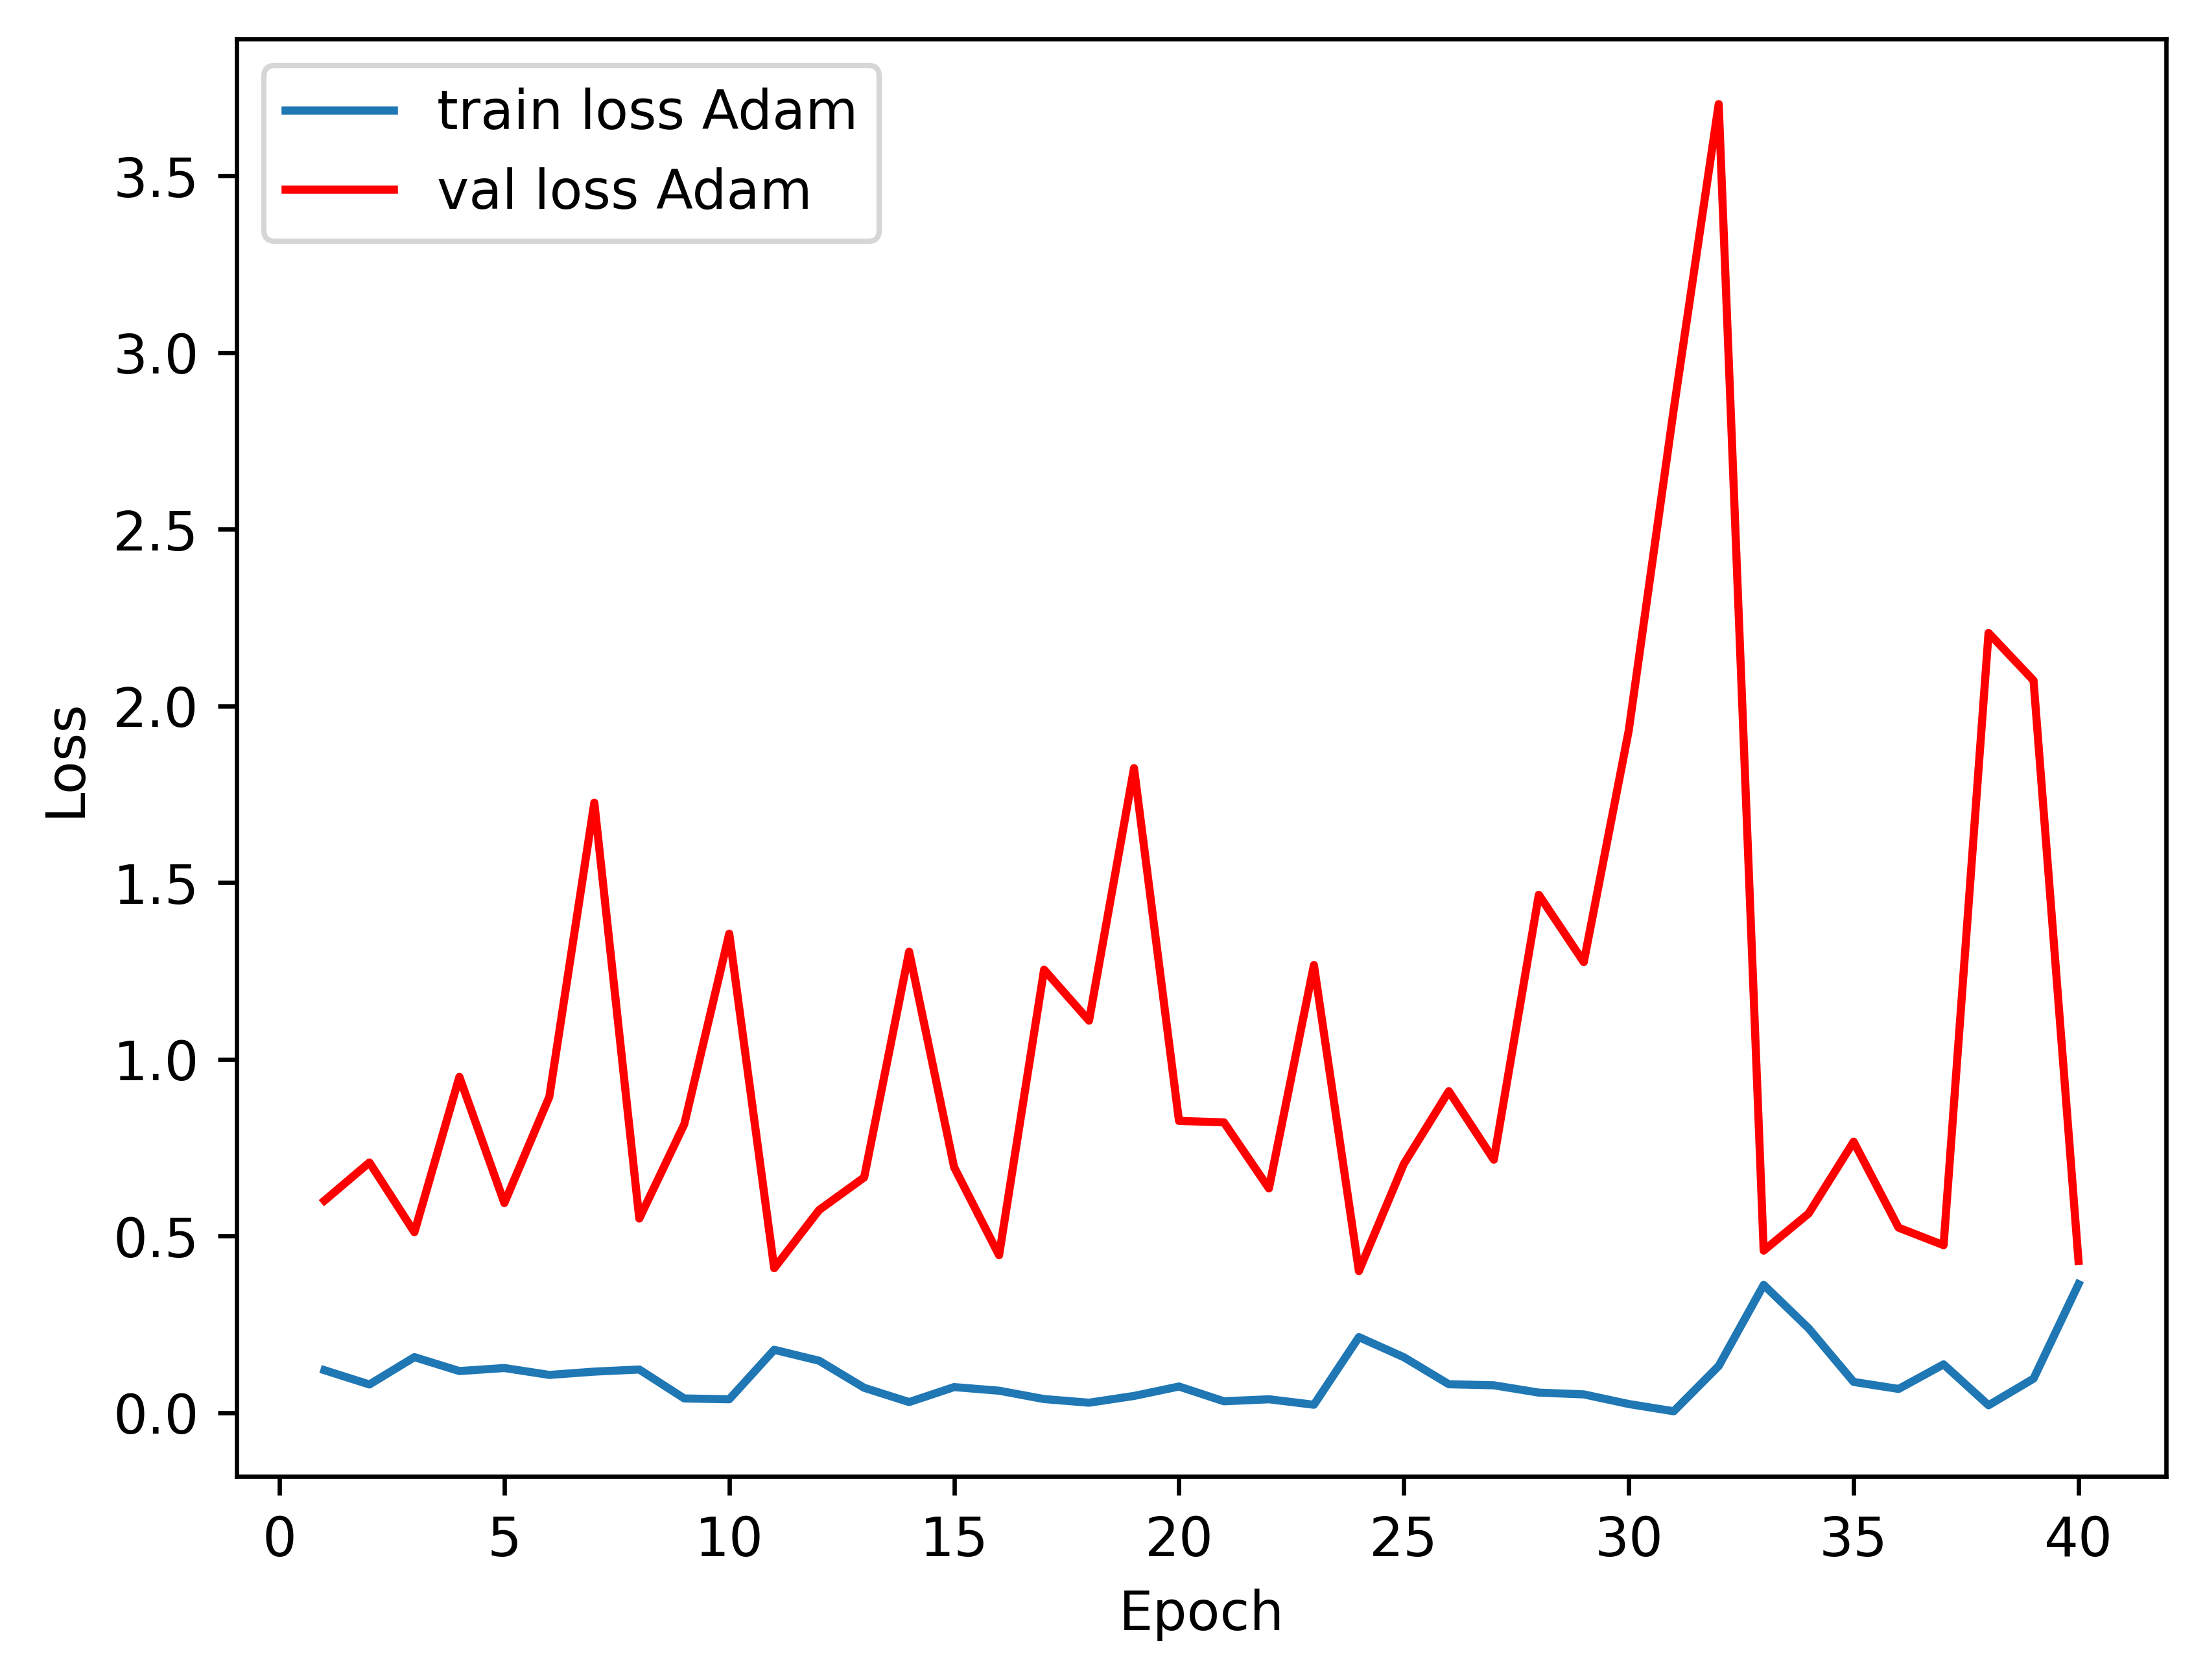

In [416]:
#plot results using the Adam Optimizer
epoch = range(1, 41)
fig = plt.figure(dpi=600)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(epoch, train_loss_list2, label='train loss Adam') # <2>
plt.plot(epoch, val_loss_list2, 'r', label='val loss Adam')
plt.legend()

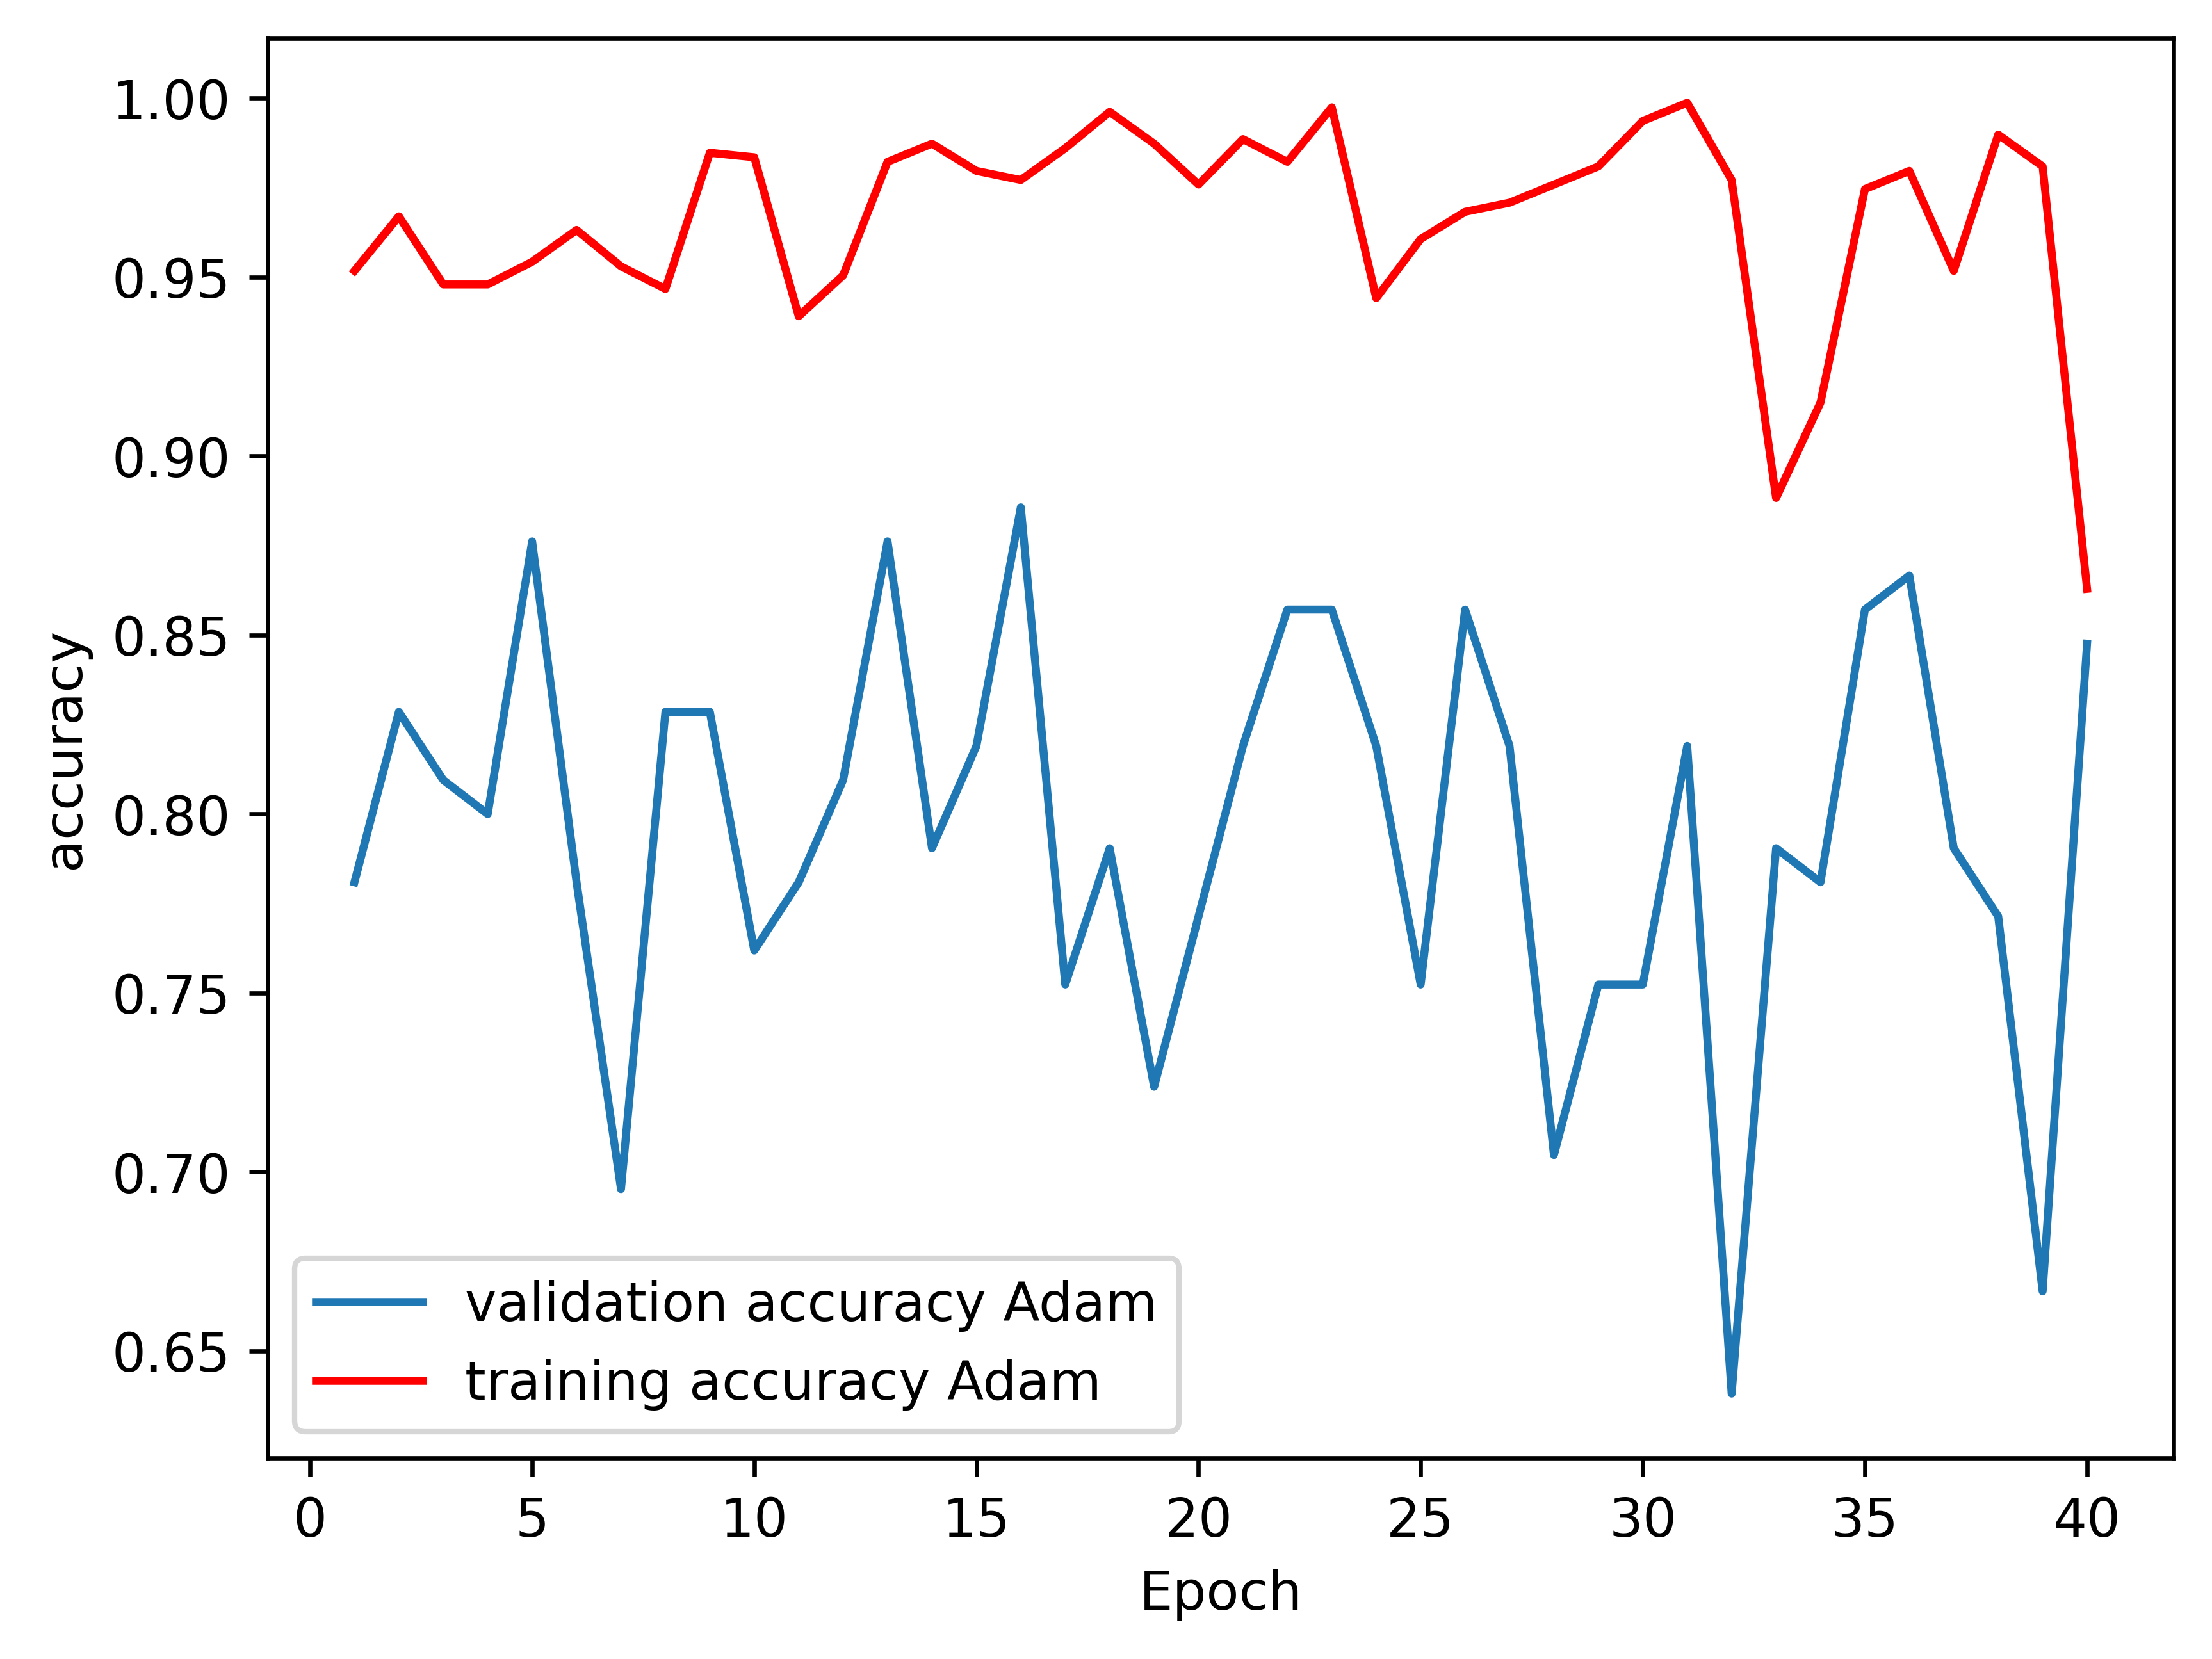

In [415]:
#plot results using the Adam Optimizer
epoch = range(1, 41)
fig = plt.figure(dpi=600)
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.plot(epoch, val_acc2, label='validation accuracy Adam') # <2>
plt.plot(epoch, train_acc2, 'r', label='training accuracy Adam')
plt.legend()

## As we observe above, the training loss and validation loss gradually reduce together over the course of 40 epochs when using the NAdam optimizer.  However, when we trained with the Adam Optimizer, the loss of each did not gradually reduced, but remained fairly low throughout the training. The lower loss from the beginning of the training may be due to the fact that the model was already trained in the previous step, and it may have inherited some of this learning from the prior training. The loss for Adam was less stable than it was for NAdam.  The accuracies over the training epochs for Adam and NAdam were similarly unstable, however, it appears that the validation accuracy for Adam had a lower variance than that of NAdam. 